<font size="10">CSIC 5011 Q1 - Q2 code</font>

<font size="4">Ng Yui Hong (20434594)</font>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import csv
import os

print(__doc__)

Automatically created module for IPython interactive environment


In [48]:
class PCA:
    def __init__(self, digit):
        print('PCA experiments \n')
        # (a) Set up data matrix
        print('(a) Set up data matrix')
        self.X = self.load_data(digit)
        print('The first 3 row of data matrix  are \n')
        print(self.X[0:3])
        print('\n')

    def load_data(self, digit):
        X = np.zeros((256,0), float)
        with open(digit, "r") as f:
            for l in f.readlines():
                line = l.split(",")
                line = np.asarray(list(map(float, line)))
                X = np.concatenate((X, np.reshape(line, (256, 1))), axis=1)
            return X
    
    def run_pca(self):
        # (b) Compute the mean and centered data matrix
        print('(b) Compute the mean and centered data matrix \n')
        mu = np.mean(self.X, axis=1, keepdims=True)
        print('The first 3 row of mean are \n')
        print(mu[0:3])
        print('\n')
        X = self.X - mu
        print('The first 3 row of centered data matrix are \n')
        print(X[0:3])
        print('\n')
        
        # (c) Apply SVD on centered data matrix
        print('(c) Apply SVD on centered data matrix \n')
        u1, s, vh = np.linalg.svd(X)
        print('The first 3 row of U matrix are \n')
        print(u1[0:3])
        print('\n')
        print('The first 3 row of diagonal matrix are \n')
        print(s[0:3])
        print('\n')
        print('The first 3 row of V matrix are \n')
        print(vh[0:3])
        print('\n')
        
        # (d) Compute the covariance matrix and apply eigen decomposition on covariance matrix 
        cov = np.dot(X, np.transpose(X)) / X.shape[1]
        w, u2 = np.linalg.eig(cov)
        
        # (d) Plot the eigen value curve
        print('(d) Plot the eigen value curve \n')
        plt.figure()
        ax = plt.subplot(111)
        plt.plot(w / np.sum(w), '.-')
        ax.set_ylabel('eigenvalue')
        ax.set_xlabel('dimension')
        plt.show("Eigenvalue_curve")
        plt.close()

        # (e) Visualize the mean and top 24 PCs
        print(' (e) Visualize the mean and top 24 PCs \n')
        plt.figure()
        plt.subplot(5,5,1)
        plt.xticks([], [])  
        plt.yticks([], [])
        plt.title("0")
        plt.imshow(np.reshape(mu, (16, 16)), cmap=plt.cm.gray_r)
        for i in range(24):
            plt.subplot(5,5,i+2)
            # plt.axis('off')
            plt.xticks([], [])  
            plt.yticks([], [])
            plt.title("%d" % (i+1))
            plt.imshow(np.reshape(u2[:,i], (16, 16)), cmap=plt.cm.gray_r)
        plt.show("Sample_mean_and_top_24_PCs")
        plt.close()

        # (f) Sort the image data according to top right singular vectors
        print('(f) Sort the image data according to top right singular vectors \n')
        k = 1
        score = np.transpose(vh)[:,0] * np.sqrt(s[0])
        sort = np.argsort(score)
        plt.figure()
        for i in range(25):
            plt.subplot(5,5,i+1)
            # plt.axis('off')
            plt.xticks([], [])  
            plt.yticks([], [])
            plt.imshow(np.reshape(self.X[:,sort[i*24]], (16, 16)), cmap=plt.cm.gray_r)
        plt.show("Sort_image_data_via_top_1_left_singular_vector")
        plt.close()

        # (g) Scatter plot image data on top 2 right singular vectors
        print('(g) Scatter plot image data on top 2 right singular vectors \n')
        k = 2
        embedding = np.transpose(vh)[:,0:k] * np.sqrt(s[0:k])
        plt.figure()
        ax = plt.subplot(1,1,1)
        plt.plot(embedding[:,0], embedding[:,1], '.r')
        ax.set_xlabel('First Principle COmponent')
        ax.set_ylabel('Second Principle COmponent')
        plt.grid(True)
        if hasattr(offsetbox, 'AnnotationBbox'):
            # only print thumbnails with matplotlib > 1.0
            shown_rows = np.array([[1., 1.]])  # just something big
            for i in range(embedding.shape[0]):
                dist = np.sum((embedding[i] - shown_rows) ** 2, 1)
                if np.min(dist) < 2e-2:
                    # don't show points that are too close
                    continue
                shown_rows = np.r_[shown_rows, [embedding[i]]]
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(np.reshape(self.X[:,i], (16,16)), cmap=plt.cm.gray_r),
                    embedding[i])
                ax.add_artist(imagebox)
        plt.show("Scatter_plot_image_data_on_top 2_right_singular_vectors")
        plt.close()

        # (f) Parallel analysis
        print('(f) Parallel analysis \n')
        n = 100
        pval = np.zeros(256, float)
        for i in range(n):
            # Get shuffled data matrix within row elements
            Xi = np.zeros((0,X.shape[1]), float)
            for j in range(X.shape[0]):
                Xi = np.concatenate((Xi, np.reshape(np.random.permutation(np.transpose(X[j,:])), (1, -1))), axis=0)
            _, si, _ = np.linalg.svd(Xi)
            pi = np.greater(si, s)
            # pval if permutated eigenvalue is greater than orginal
            pval = pval + pi.astype(float)
        plt.figure()
        ax = plt.subplot(111)
        ax.set_xlabel('dimensions (log scale)')
        ax.set_ylabel('eigenvalue')
        ax.set_yscale('log')
        ax.set_xscale('log')
        plt.plot(s, '.--r', label='original')
        plt.plot(si, '.--b', label='permuted')
        
        ax2 = ax.twinx()
        ax2.set_ylabel('p-values')
        plt.plot(pval/n, 'g', label='p-value')
        ax.legend(loc='lower left')
        ax2.legend(loc='upper right')
        plt.show("Parallel_analysis")
        plt.close()

In [49]:
class MDS:
    def __init__(self, dist):
        #load data and construct squared distance matrix
        print('2. MDS of cities \n')
        self.label, self.D = self.load_data(dist)
        self.H = np.eye(self.D.shape[0]) - np.ones(self.D.shape[0]) / self.D.shape[0]
    
    def load_data(self, dist):
        D = []
        with open(dist, newline='') as csvfile:
            rows = csv.reader(csvfile)
            for row in rows:
                D.append(row)
        label = D[0]
        D = np.array(D[1:])
        D[D=='']='0'
        D = D.astype(float)
        D = D + np.transpose(D)
        D = D * D
        return label, D

    def run_mds(self):
        # MDS algorithm
        B = np.dot(np.dot(self.H, self.D), self.H) / -2
        w, v = np.linalg.eig(B)
        
        # Plot normalized eigenvalues
        print('Plot normalized eigenvalues \n')
        plt.figure()
        ax = plt.subplot(111)
        plt.plot(w / np.sum(w), '.-')
        ax.set_ylabel('eigenvalue')
        ax.set_xlabel('dimension')
        plt.show("MDS_eigenvalue")
        plt.close()

        # Scatter plot of cities using top 2 eigenvectors
        print('Scatter plot of cities using top 2 eigenvectors \n')
        k = 2
        embedding = v[:, 0:k] * np.sqrt(w[0:k])
        plt.figure()
        ax = plt.subplot(1,1,1)
        plt.plot(embedding[:,0], embedding[:,1], 'or')
        ax.set_xlabel('First Principle COmponent')
        ax.set_ylabel('Second Principle COmponent')
        plt.grid(True)
        for i in range(embedding.shape[0]):
            plt.text(embedding[i, 0], embedding[i, 1], self.label[i],
                    color=plt.cm.Set1(i / 10.),
                    fontdict={'weight': 'bold', 'size': 15})
        plt.show("2D_scatter_plot_cities")
        plt.close()

PCA experiments 

(a) Set up data matrix
The first 3 row of data matrix  are 

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


(b) Compute the mean and centered data matrix 

The first 3 row of mean are 

[[-0.9975152 ]
 [-0.98044225]
 [-0.91253799]]


The first 3 row of centered data matrix are 

[[-0.0024848  -0.0024848  -0.0024848  ... -0.0024848  -0.0024848
  -0.0024848 ]
 [-0.01955775 -0.01955775 -0.01955775 ... -0.01955775 -0.01955775
  -0.01955775]
 [-0.08746201 -0.08746201 -0.08746201 ... -0.08746201 -0.08746201
  -0.08746201]]


(c) Apply SVD on centered data matrix 

The first 3 row of U matrix are 

[[ 1.09961154e-03 -2.81966486e-04  7.08380759e-04 -6.41172185e-04
   2.20532753e-03 -2.81262547e-04  4.35937933e-04 -8.41635604e-04
   8.74667898e-04 -5.54869124e-04  1.42303102e-03 -1.16338683e-03
   1.98412394e-03 -5.11422291e-04  5.48466757e-04 -3.94027682e-03
   2.06271282e-03 -3.33400812e-03  6.29879584e-04 -4.30849045e-03
  -6

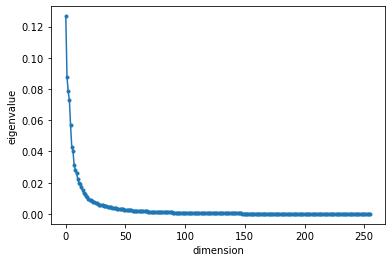

 (e) Visualize the mean and top 24 PCs 



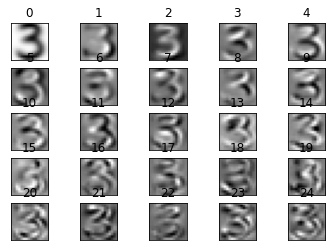

(f) Sort the image data according to top right singular vectors 



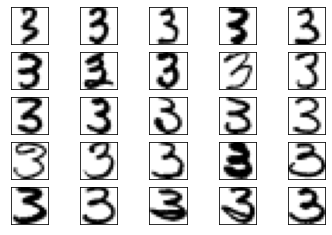

(g) Scatter plot image data on top 2 right singular vectors 



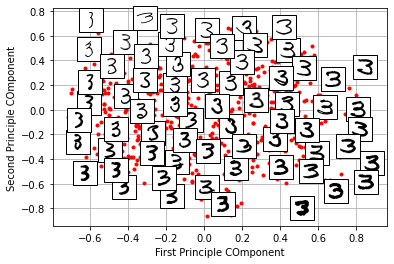

(f) Parallel analysis 



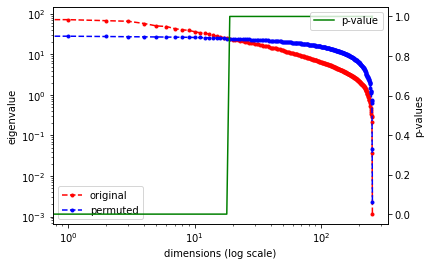

2. MDS of cities 

Plot normalized eigenvalues 



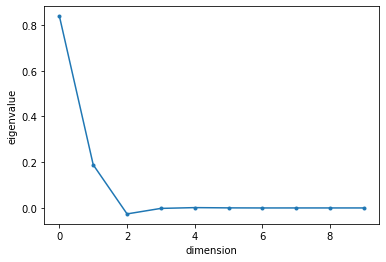

Scatter plot of cities using top 2 eigenvectors 



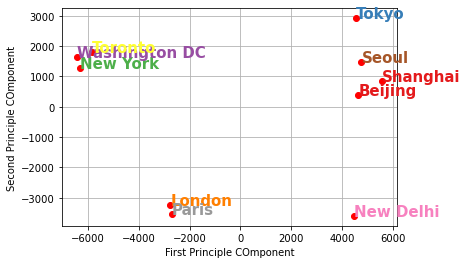

In [50]:
if __name__ == '__main__':
    pca = PCA("train3.csv")
    pca.run_pca()
    mds = MDS("distance.csv")
    mds.run_mds()